# Environment Configuration

In [1]:
import os

DEVICE = 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 657 kB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Data Preparation

## Download Datasets

Clone the repo containing ATIS and SNIPS and set their paths to be used later.

In [3]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets.git

DATASET_PATHS = {"ATIS": "./IntentSlotDatasets/ATIS/", 
                 "SNIPS": "./IntentSlotDatasets/SNIPS/"}

Cloning into 'IntentSlotDatasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 9), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (40/40), done.


## Load Data

Load the datasets into a dictionary `dataset[dataset_name][split]` is a list of samples containing an utterance, intent, and a slot.

In [4]:
import os
import json
from pprint import pprint

dataset = dict()

for name, path in DATASET_PATHS.items():
    dataset[name] = dict()
    for split in ["train", "test", "valid"]:
        split_path = os.path.join(path, split + ".json")
        if os.path.exists(split_path):
            with open(split_path) as fp:
                dataset[name][split] = json.load(fp)
                print(name, split, len(dataset[name][split]))

pprint(dataset['ATIS']['train'][0])

ATIS train 4978
ATIS test 893
SNIPS train 13084
SNIPS test 700
SNIPS valid 700
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


## Lang and Dataset Classes

The `Lang` class stores information about the vocabulary and output labels. Each word/intent/slot label is mapped to an integer. These integers are then fed into the embedding layers of the neural models.

`Dataset` is for dividing the whole dataset into smaller batches.

In [5]:
import torch
import torch.utils.data as data

class Lang:
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self):
        self._vocab = []
        self._word_ids = dict()
        self._intents = []
        self._intent_ids = dict()
        self._slots = []
        self._slot_ids = dict()

    def build_vocab(self, data):
        vocab = set()
        for x in data:
            vocab = vocab.union(set(x['utterance'].split()))
        self._vocab = [Lang.PAD_TOKEN] + list(vocab) + [Lang.UNK_TOKEN]
        self._word_ids = dict((w, i) for i, w in enumerate(self._vocab))

    def build_intents(self, data):
        self._intents = list(set(x['intent'] for x in data))
        self._intent_ids = dict((w, i) for i, w in enumerate(self._intents))

    def build_slots(self, data):
        slots = set()
        for x in data:
            slots = slots.union(set(x['slots'].split()))
        self._slots = list(slots)
        self._slot_ids = dict((w, i) for i, w in enumerate(self._slots))
    
    def get_word_id(self, word):
        if word in self._word_ids:
            return self._word_ids[word]
        else:
            return self._word_ids[Lang.UNK_TOKEN]
    
    def get_intent_id(self, intent):
        return self._intent_ids[intent]
    
    def get_slot_id(self, intent):
        return self._slot_ids[intent]
    
    def get_slot_label(self, i):
        return self._slots[i]

    def get_intent_label(self, i):
        return self._intents[i]
    
    def get_word(self, i):
        return self._vocab[i]
    
    @property
    def vocab_size(self):
        return len(self._vocab)
    
    @property
    def num_intents(self):
        return len(self._intents)
    
    @property
    def num_slots(self):
        return len(self._slots)
    
    @property
    def vocab(self):
        return self._vocab

class Dataset(data.Dataset):

    def __init__(self, data, lang):
        self._x = []
        self._y_intent = []
        self._y_slot = []

        for sample in data:
            utter_ids = list(map(lang.get_word_id, sample['utterance'].split()))
            slot_ids = list(map(lang.get_slot_id, sample['slots'].split()))
            self._x.append(utter_ids)
            self._y_slot.append(slot_ids)
            self._y_intent.append(lang.get_intent_id(sample['intent']))
    
    def __len__(self):
        return len(self._x)

    def __getitem__(self, i):
        x = torch.Tensor(self._x[i])
        y_intent = self._y_intent[i]
        y_slot = torch.Tensor(self._y_slot[i])
        return {'utterance': x, 'intent': y_intent, 'slots': y_slot}

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(DEVICE)
    y_slots = y_slots.to(DEVICE)
    intent = intent.to(DEVICE)
    y_lengths = torch.LongTensor(y_lengths).to(DEVICE)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


# Bi-model RNN

Wang, Yu, Yilin Shen, and Hongxia Jin. "A bi-model based rnn semantic frame parsing model for intent detection and slot filling." arXiv preprint [arXiv:1812.10235](https://arxiv.org/abs/1812.10235) (2018).

Original code: https://github.com/ray075hl/Bi-Model-Intent-And-Slot

In [6]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiModelRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(BiModelRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._intent_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_intent1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_intent2 = nn.Linear(2 * hidden_dim, num_intents)
        self._slot_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_slot1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_slot2 = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, input, seq_lens):
        x = self._embed(input).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        with torch.no_grad():
            _, (h1, s1) = self._intent_enc(x)
            _, (h2, s2) = self._slot_enc(x)
        y_intent, _ = self._intent_enc(x, (h2, s1))
        y_slot, _ = self._slot_enc(x, (h1, s2))
        y_intent = self._y_intent1(pad_packed_sequence(y_intent)[0])
        y_slot = self._y_slot1(pad_packed_sequence(y_slot)[0])
        self._h_intent, self._s_intent = h1.detach(), s1.detach()
        self._h_slot, self._s_slot = h2.detach(), s2.detach()
        return self._y_intent2(y_intent[-1,:,:]), self._y_slot2(y_slot).permute(1, 2, 0)


# Attention Bi-RNN

Liu, Bing, and Ian Lane. "Attention-based recurrent neural network models for joint intent detection and slot filling." arXiv preprint [arXiv:1609.01454](https://arxiv.org/pdf/1609.01454.pdf) (2016).

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionBiRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(AttentionBiRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._blstm = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._attention = nn.MultiheadAttention(2 * hidden_dim, 4)
        self._y_intent = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, x, seq_lens):
        x = self._embed(x).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        x, _ = self._blstm(x)
        x, _ = pad_packed_sequence(x)
        x, _ = self._attention(x, x, x)
        return self._y_intent(x[-1,:,:]), self._y_slot(x).permute(1, 2, 0)

# BERT

Chen, Qian, Zhu Zhuo, and Wen Wang. "Bert for joint intent classification and slot filling." arXiv preprint [arXiv:1902.10909](https://arxiv.org/abs/1902.10909) (2019).

In [8]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer

class BERT(nn.Module):

    def __init__(self, num_intents, num_slots, lang):
        super(BERT, self).__init__()
        self._lang = lang
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', never_split=lang.vocab)
        self._tokenizer.add_tokens(lang.vocab)
        self._bert = BertModel.from_pretrained('bert-base-uncased')
        self._bert.to(DEVICE)
        self._bert.resize_token_embeddings(len(self._tokenizer))
        self._intent = nn.Linear(self._bert.config.hidden_size, num_intents)
        self._slots = nn.Linear(self._bert.config.hidden_size, num_slots)
    
    def _to_text(self, input):
        texts = []
        for sample in input:
            texts.append(' '.join(lang.get_word(i) for i in sample if i > 0))
        return texts
    
    def forward(self, input, seq_lens):
        with torch.no_grad():
            encoding = self._tokenizer(self._to_text(input),
                                        add_special_tokens=True,   
                                        truncation=True,
                                        padding=True,
                                        return_tensors="pt").to(DEVICE)
            bert_output = self._bert(**encoding)
        x_intent = bert_output.pooler_output
        x_slots = bert_output.last_hidden_state[:,:input.size()[1],:]
        return self._intent(x_intent), self._slots(x_slots).permute(0, 2, 1)

# Experimenting

This cell contains code for performing experiments. Modify the `DATASET`, `NUM_EPOCHS` and `model` variables for different setups. Re-run this cell 5 times to gather results for the report.

In [10]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from conlleval import evaluate

DATASET = 'SNIPS'
NUM_EPOCHS = 100

lang = Lang()
lang.build_vocab(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_intents(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_slots(dataset[DATASET]['train'] + dataset[DATASET]['test'])

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(dataset[DATASET]['train'], lang)
test_dataset = Dataset(dataset[DATASET]['test'], lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
# model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# model = BERT(lang.num_intents, lang.num_slots, lang)
model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
for epoch in range(NUM_EPOCHS):
    total_loss_values = []

    # Training loop
    for sample in tqdm(train_loader, desc="Epoch " + str(epoch) + "/" + str(NUM_EPOCHS)):
        optimizer.zero_grad()
        intent, slots = model(sample['utterances'], sample['slots_len'])
        intent_loss = intent_loss_fn(intent, sample['intents'])
        slot_loss = slot_loss_fn(slots, sample['y_slots'])
        # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
        loss = intent_loss + slot_loss # + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss.append(np.mean(total_loss_values))

    ref_intents = []
    hyp_intents = []
        
    ref_slots = []
    hyp_slots = []

    total_loss_values = []

    # Evaluation loop
    with torch.no_grad():
            for sample in test_loader:
                intent, slots = model(sample['utterances'], sample['slots_len'])
                intent_loss = intent_loss_fn(intent, sample['intents'])
                slot_loss = slot_loss_fn(slots, sample['y_slots'])
                # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
                loss = intent_loss + slot_loss # + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
                total_loss_values.append(loss.item())
                out_intents = [lang.get_intent_label(x)
                            for x in torch.argmax(intent, dim=1).tolist()]
                gt_intents = [lang.get_intent_label(x) for x in sample['intents'].tolist()]  
                ref_intents.extend(gt_intents)
                hyp_intents.extend(out_intents) 

                output_slots = torch.argmax(slots, dim=1)
                for id_seq, seq in enumerate(output_slots):
                    length = sample['slots_len'].tolist()[id_seq]
                    utt_ids = sample['utterance'][id_seq][:length].tolist()
                    gt_ids = sample['y_slots'][id_seq].tolist()
                    gt_slots = [lang.get_slot_label(elem) for elem in gt_ids[:length]]
                    utterance = [lang.get_word(int(elem)) for elem in utt_ids]
                    to_decode = seq[:length].tolist()
                    ref_slots.append(gt_slots)
                    tmp_seq = []
                    for id_el, elem in enumerate(to_decode):
                        tmp_seq.append(lang.get_slot_label(elem))
                    hyp_slots.append(tmp_seq)
    test_loss.append(np.mean(total_loss_values))
    f1s = []
    for ref, hyp in zip(ref_slots, hyp_slots):
        _, _, f1 = evaluate(ref, hyp, verbose=False)
        f1s.append(f1)
    slots_f1.append(np.mean(f1s) / 100)

    report_intent = classification_report(ref_intents, hyp_intents, 
                                            zero_division=False, output_dict=True)
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

print("F1 =", max(slots_f1))
print("Acc =", max(intent_acc))

Vocab size = 11791
No. intents = 7
No. slots = 72


Epoch 0/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 3.447826692201559
Training perplexity = 31.43200659900451
Validation loss = 1.4295461719686335
Validation perplexity = 4.176803211352409
Slot filling F1 = 0.0001680672268907563
Intent detection acc. = 0.8057142857142857


Epoch 1/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.9939227763888905
Training perplexity = 2.7018123170896855
Validation loss = 0.9127159172838385
Validation perplexity = 2.4910789186305577
Slot filling F1 = 0.08188593152878866
Intent detection acc. = 0.8328571428571429


Epoch 2/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.7060308508502627
Training perplexity = 2.025934044691753
Validation loss = 0.7940061092376709
Validation perplexity = 2.212241177724644
Slot filling F1 = 0.13358375751232893
Intent detection acc. = 0.8342857142857143


Epoch 3/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.5981009243761451
Training perplexity = 1.8186617426389593
Validation loss = 0.7472239786928351
Validation perplexity = 2.1111313290289972
Slot filling F1 = 0.18065415536844107
Intent detection acc. = 0.8414285714285714


Epoch 4/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.5318346689048322
Training perplexity = 1.702052147957582
Validation loss = 0.7153679674321954
Validation perplexity = 2.044939014791402
Slot filling F1 = 0.24262467691039116
Intent detection acc. = 0.8371428571428572


Epoch 5/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.47610006170365415
Training perplexity = 1.6097840856379733
Validation loss = 0.6896529983390461
Validation perplexity = 1.9930238306594907
Slot filling F1 = 0.28934109541252395
Intent detection acc. = 0.8371428571428572


Epoch 6/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.41892960855683076
Training perplexity = 1.5203333325661383
Validation loss = 0.6428331678563898
Validation perplexity = 1.9018615465400384
Slot filling F1 = 0.3524061335489906
Intent detection acc. = 0.8371428571428572


Epoch 7/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.356866266831611
Training perplexity = 1.4288447731375293
Validation loss = 0.6408944644711234
Validation perplexity = 1.898177972953492
Slot filling F1 = 0.3855837575123289
Intent detection acc. = 0.8371428571428572


Epoch 8/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.3031936481739711
Training perplexity = 1.3541766728933151
Validation loss = 0.6306237144903704
Validation perplexity = 1.8787820374796582
Slot filling F1 = 0.431595190523762
Intent detection acc. = 0.8371428571428572


Epoch 9/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.2530241274428599
Training perplexity = 1.2879143505396655
Validation loss = 0.6144894442775033
Validation perplexity = 1.8487124878281003
Slot filling F1 = 0.5121267779839208
Intent detection acc. = 0.8357142857142857


Epoch 10/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.20201866835066415
Training perplexity = 1.2238708555483944
Validation loss = 0.5816532590172507
Validation perplexity = 1.7889936570950506
Slot filling F1 = 0.553282265353694
Intent detection acc. = 0.8385714285714285


Epoch 11/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.16066844761371613
Training perplexity = 1.174295563766983
Validation loss = 0.5871015868403695
Validation perplexity = 1.7987672817911644
Slot filling F1 = 0.5973901416044273
Intent detection acc. = 0.8357142857142857


Epoch 12/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.12585344975723803
Training perplexity = 1.1341159511357817
Validation loss = 0.6185580302368511
Validation perplexity = 1.8562494555025146
Slot filling F1 = 0.6146217512646084
Intent detection acc. = 0.8342857142857143


Epoch 13/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.09686920415718579
Training perplexity = 1.1017162642894354
Validation loss = 0.6215592270547693
Validation perplexity = 1.8618287936196907
Slot filling F1 = 0.6250918367346938
Intent detection acc. = 0.8342857142857143


Epoch 14/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.07718924255770387
Training perplexity = 1.0802464856584209
Validation loss = 0.6240594685077667
Validation perplexity = 1.866489639339728
Slot filling F1 = 0.6616871739371739
Intent detection acc. = 0.83


Epoch 15/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.06016903168078765
Training perplexity = 1.0620160457316412
Validation loss = 0.6570505662397905
Validation perplexity = 1.9290941998379263
Slot filling F1 = 0.6706304806304807
Intent detection acc. = 0.8328571428571429


Epoch 16/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.04731472666619472
Training perplexity = 1.0484519329405337
Validation loss = 0.657637582583861
Validation perplexity = 1.9302269420990656
Slot filling F1 = 0.6914043496186353
Intent detection acc. = 0.8328571428571429


Epoch 17/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.036974976797705714
Training perplexity = 1.037667054760656
Validation loss = 0.6794131018898704
Validation perplexity = 1.972719607003771
Slot filling F1 = 0.6892670821242249
Intent detection acc. = 0.8357142857142857


Epoch 18/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.031121034066653945
Training perplexity = 1.0316103563272996
Validation loss = 0.7139109779487957
Validation perplexity = 2.041961729615938
Slot filling F1 = 0.6926777270348699
Intent detection acc. = 0.8328571428571429


Epoch 19/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.06290229353872896
Training perplexity = 1.0649227843111873
Validation loss = 0.7025305493311449
Validation perplexity = 2.018855061193538
Slot filling F1 = 0.693717377860235
Intent detection acc. = 0.8257142857142857


Epoch 20/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.06370807428238462
Training perplexity = 1.0657812243950624
Validation loss = 0.5751608393409036
Validation perplexity = 1.7774163824044749
Slot filling F1 = 0.7094241393527108
Intent detection acc. = 0.8385714285714285


Epoch 21/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.029456853296933243
Training perplexity = 1.0298949979395662
Validation loss = 0.5906416408040307
Validation perplexity = 1.8051462994082632
Slot filling F1 = 0.7205531849103276
Intent detection acc. = 0.8414285714285714


Epoch 22/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.017463457481302683
Training perplexity = 1.0176168351890869
Validation loss = 0.632162715901028
Validation perplexity = 1.8816757117989422
Slot filling F1 = 0.7281975167689454
Intent detection acc. = 0.84


Epoch 23/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.012884743168082052
Training perplexity = 1.012968109136254
Validation loss = 0.6720774295655164
Validation perplexity = 1.958301330909821
Slot filling F1 = 0.7258332619761191
Intent detection acc. = 0.8414285714285714


Epoch 24/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.009642594475841638
Training perplexity = 1.0096892340783423
Validation loss = 0.7016665393655951
Validation perplexity = 2.0171115036356846
Slot filling F1 = 0.7253233671090813
Intent detection acc. = 0.8414285714285714


Epoch 25/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.008130463893588596
Training perplexity = 1.0081636058741539
Validation loss = 0.7318356226791035
Validation perplexity = 2.078893170841706
Slot filling F1 = 0.7244455782312924
Intent detection acc. = 0.8414285714285714


Epoch 26/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.006741560855428282
Training perplexity = 1.0067643363287926
Validation loss = 0.7553868212483146
Validation perplexity = 2.128434687899195
Slot filling F1 = 0.7264043813329526
Intent detection acc. = 0.8385714285714285


Epoch 27/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0061392174588371685
Training perplexity = 1.0061581010781109
Validation loss = 0.7848237509077246
Validation perplexity = 2.192020565050195
Slot filling F1 = 0.7263869305297876
Intent detection acc. = 0.84


Epoch 28/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005382454592409065
Training perplexity = 1.0053969660251558
Validation loss = 0.7852147329937328
Validation perplexity = 2.1928777733889238
Slot filling F1 = 0.7304097093382806
Intent detection acc. = 0.84


Epoch 29/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005074931707603911
Training perplexity = 1.0050878309852753
Validation loss = 0.8052899566563693
Validation perplexity = 2.237345137892161
Slot filling F1 = 0.7299632034632034
Intent detection acc. = 0.8385714285714285


Epoch 30/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0042495859529172045
Training perplexity = 1.0042586282474348
Validation loss = 0.8305554633790796
Validation perplexity = 2.294592948696255
Slot filling F1 = 0.7393329210472068
Intent detection acc. = 0.8357142857142857


Epoch 31/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.003761832342365558
Training perplexity = 1.0037689169145236
Validation loss = 0.8417225019498304
Validation perplexity = 2.3203603617344357
Slot filling F1 = 0.7346805813234384
Intent detection acc. = 0.8385714285714285


Epoch 32/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005690740039391281
Training perplexity = 1.0057069630595534
Validation loss = 0.86137009750713
Validation perplexity = 2.3664006733183522
Slot filling F1 = 0.7249118976261834
Intent detection acc. = 0.8371428571428572


Epoch 33/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.004313991405069828
Training perplexity = 1.0043233100613738
Validation loss = 0.8475722589276053
Validation perplexity = 2.333973684445958
Slot filling F1 = 0.738184188827046
Intent detection acc. = 0.8357142857142857


Epoch 34/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.004642786750868324
Training perplexity = 1.0046535811842274
Validation loss = 0.8687853731892325
Validation perplexity = 2.384013407620634
Slot filling F1 = 0.7170931766646053
Intent detection acc. = 0.8357142857142857


Epoch 35/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.012046234899209541
Training perplexity = 1.012119083008099
Validation loss = 0.8135602528398688
Validation perplexity = 2.2559253709587517
Slot filling F1 = 0.7369614512471655
Intent detection acc. = 0.8371428571428572


Epoch 36/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.009004325960826093
Training perplexity = 1.0090449868535112
Validation loss = 0.8041336455128409
Validation perplexity = 2.2347595659282224
Slot filling F1 = 0.7474164327735755
Intent detection acc. = 0.8371428571428572


Epoch 37/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.008066917403411228
Training perplexity = 1.008099542650994
Validation loss = 0.8397290354425256
Validation perplexity = 2.3157394084565066
Slot filling F1 = 0.7392462299605156
Intent detection acc. = 0.8342857142857143


Epoch 38/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.006548429334093138
Training perplexity = 1.006569917175729
Validation loss = 0.8313612260601737
Validation perplexity = 2.296442591148973
Slot filling F1 = 0.7468398268398269
Intent detection acc. = 0.8357142857142857


Epoch 39/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.006759168644598459
Training perplexity = 1.0067820633790372
Validation loss = 0.8322153850035234
Validation perplexity = 2.298404956092566
Slot filling F1 = 0.7534890506319079
Intent detection acc. = 0.8328571428571429


Epoch 40/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005368375850081878
Training perplexity = 1.0053828113999745
Validation loss = 0.8558484532616355
Validation perplexity = 2.3533702584222302
Slot filling F1 = 0.7611102865388579
Intent detection acc. = 0.8314285714285714


Epoch 41/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0031625831779996745
Training perplexity = 1.00316758942034
Validation loss = 0.840891111980785
Validation perplexity = 2.318432039110235
Slot filling F1 = 0.7551926406926407
Intent detection acc. = 0.8314285714285714


Epoch 42/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.002007646734252102
Training perplexity = 1.0020096634063194
Validation loss = 0.8506548675623807
Validation perplexity = 2.341179512546832
Slot filling F1 = 0.7546204906204906
Intent detection acc. = 0.8342857142857143


Epoch 43/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0017046163949857747
Training perplexity = 1.001706070079387
Validation loss = 0.8848772103136237
Validation perplexity = 2.422686892257317
Slot filling F1 = 0.7560916305916306
Intent detection acc. = 0.8314285714285714


Epoch 44/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0010660989003739708
Training perplexity = 1.0010666673858093
Validation loss = 0.8879981718280099
Validation perplexity = 2.430259816064395
Slot filling F1 = 0.7525569906284191
Intent detection acc. = 0.8328571428571429


Epoch 45/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0010142654065524218
Training perplexity = 1.0010147799476556
Validation loss = 0.8940683061426337
Validation perplexity = 2.4450566836196788
Slot filling F1 = 0.7533314701171844
Intent detection acc. = 0.8314285714285714


Epoch 46/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0009121494831119492
Training perplexity = 1.0009125656179678
Validation loss = 0.9030034975572065
Validation perplexity = 2.467001628245175
Slot filling F1 = 0.7557381903810474
Intent detection acc. = 0.83


Epoch 47/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.001364269519046184
Training perplexity = 1.0013652005580544
Validation loss = 0.9325710101561113
Validation perplexity = 2.5410338103086887
Slot filling F1 = 0.7490786435786435
Intent detection acc. = 0.8342857142857143


Epoch 48/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.002523760881514551
Training perplexity = 1.0025269482468266
Validation loss = 0.9398596530610864
Validation perplexity = 2.559622157984668
Slot filling F1 = 0.7552799739942597
Intent detection acc. = 0.8328571428571429


Epoch 49/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005010782389786294
Training perplexity = 1.0050233573545626
Validation loss = 0.9370145472613248
Validation perplexity = 2.5523501119133885
Slot filling F1 = 0.7474862914862913
Intent detection acc. = 0.83


Epoch 50/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.011542234680552071
Training perplexity = 1.0116091032946943
Validation loss = 0.8026707930998369
Validation perplexity = 2.231492832461738
Slot filling F1 = 0.7478624550053122
Intent detection acc. = 0.84


Epoch 51/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.012975259523531332
Training perplexity = 1.013059803467535
Validation loss = 0.8631424389102242
Validation perplexity = 2.3705984620665452
Slot filling F1 = 0.7499871794871795
Intent detection acc. = 0.8357142857142857


Epoch 52/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.012903101144367558
Training perplexity = 1.0129867053514734
Validation loss = 1.07529263604771
Validation perplexity = 2.930850447544396
Slot filling F1 = 0.7372390149533007
Intent detection acc. = 0.8214285714285714


Epoch 53/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.04978231069387742
Training perplexity = 1.0510422708078504
Validation loss = 0.645042210817337
Validation perplexity = 1.9060674842402852
Slot filling F1 = 0.7539151245579816
Intent detection acc. = 0.8414285714285714


Epoch 54/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.022806159767674878
Training perplexity = 1.0230682085463458
Validation loss = 0.6048529066822745
Validation perplexity = 1.830982863732698
Slot filling F1 = 0.7617460317460316
Intent detection acc. = 0.8385714285714285


Epoch 55/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0057203488331740195
Training perplexity = 1.0057367412704747
Validation loss = 0.6195445250381123
Validation perplexity = 1.8580815394622852
Slot filling F1 = 0.7788220470006185
Intent detection acc. = 0.8442857142857143


Epoch 56/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.002475903426563747
Training perplexity = 1.0024789710066075
Validation loss = 0.6873919638720426
Validation perplexity = 1.9885226256922144
Slot filling F1 = 0.7757440733869305
Intent detection acc. = 0.8314285714285714


Epoch 57/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0010242378534138818
Training perplexity = 1.0010247625641315
Validation loss = 0.6942294294183905
Validation perplexity = 2.002165669402129
Slot filling F1 = 0.7757282003710574
Intent detection acc. = 0.8371428571428572


Epoch 58/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0006459404147022124
Training perplexity = 1.0006461490791376
Validation loss = 0.712152895602313
Validation perplexity = 2.0383749466007086
Slot filling F1 = 0.7740667903525046
Intent detection acc. = 0.8385714285714285


Epoch 59/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.00045765976724440903
Training perplexity = 1.000457764509454
Validation loss = 0.7252446060830896
Validation perplexity = 2.065236207527155
Slot filling F1 = 0.7750633889919604
Intent detection acc. = 0.84


Epoch 60/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.00037575345777440816
Training perplexity = 1.0003758240619478
Validation loss = 0.7353103323416277
Validation perplexity = 2.086129285447957
Slot filling F1 = 0.7769556792413935
Intent detection acc. = 0.84


Epoch 61/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0003195619093337847
Training perplexity = 1.00031961297468
Validation loss = 0.7488069317557595
Validation perplexity = 2.1144757972022243
Slot filling F1 = 0.7748332302618016
Intent detection acc. = 0.84


Epoch 62/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.00025826167560790586
Training perplexity = 1.0002582950280257
Validation loss = 0.7616760893301531
Validation perplexity = 2.1418631676371014
Slot filling F1 = 0.7756647083075654
Intent detection acc. = 0.84


Epoch 63/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0002541762557828989
Training perplexity = 1.0002542085613044
Validation loss = 0.7718822874806144
Validation perplexity = 2.1638353831997326
Slot filling F1 = 0.7767686044114616
Intent detection acc. = 0.84


Epoch 64/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0002168768261575131
Training perplexity = 1.0002169003456367
Validation loss = 0.7795004140246998
Validation perplexity = 2.1803827047361515
Slot filling F1 = 0.778118944547516
Intent detection acc. = 0.84


Epoch 65/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.00024027764730526189
Training perplexity = 1.0002403065162913
Validation loss = 0.7871627347035841
Validation perplexity = 2.1971536664122926
Slot filling F1 = 0.7761178107606679
Intent detection acc. = 0.84


Epoch 66/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0002660811907703337
Training perplexity = 1.0002661165935103
Validation loss = 0.7951292043382471
Validation perplexity = 2.214727130672124
Slot filling F1 = 0.775777674706246
Intent detection acc. = 0.84


Epoch 67/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0001603680370642252
Training perplexity = 1.0001603808967052
Validation loss = 0.8012989840724252
Validation perplexity = 2.2284337491683317
Slot filling F1 = 0.776945475159761
Intent detection acc. = 0.84


Epoch 68/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0003876930971370526
Training perplexity = 1.0003877682598188
Validation loss = 0.8019070625305176
Validation perplexity = 2.2297892238021833
Slot filling F1 = 0.770549062049062
Intent detection acc. = 0.84


Epoch 69/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0019341475873235025
Training perplexity = 1.001936019257269
Validation loss = 0.8271727155555378
Validation perplexity = 2.2868440330960538
Slot filling F1 = 0.7685863739435167
Intent detection acc. = 0.8385714285714285


Epoch 70/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0031809534676072357
Training perplexity = 1.0031860180687517
Validation loss = 0.7829160229726271
Validation perplexity = 2.187842772496785
Slot filling F1 = 0.7631169861884147
Intent detection acc. = 0.8371428571428572


Epoch 71/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.00629735995565532
Training perplexity = 1.006317230014601
Validation loss = 0.7564249688928778
Validation perplexity = 2.1306454647148607
Slot filling F1 = 0.7711320108462965
Intent detection acc. = 0.8357142857142857


Epoch 72/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.005493093037286104
Training perplexity = 1.0055082077356523
Validation loss = 0.8000107678500089
Validation perplexity = 2.225564892912397
Slot filling F1 = 0.7698168656740085
Intent detection acc. = 0.8342857142857143


Epoch 73/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.002940136065607149
Training perplexity = 1.0029444625047168
Validation loss = 0.7964644730091095
Validation perplexity = 2.217686361668761
Slot filling F1 = 0.7754251700680272
Intent detection acc. = 0.8385714285714285


Epoch 74/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.002253118172306025
Training perplexity = 1.002255658350471
Validation loss = 0.768779375336387
Validation perplexity = 2.1571315981178696
Slot filling F1 = 0.7820595158809445
Intent detection acc. = 0.8371428571428572


Epoch 75/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 0.0010676461061998497
Training perplexity = 1.0010682162431874
Validation loss = 0.8197502060370012
Validation perplexity = 2.269932751210319
Slot filling F1 = 0.7781405284724612
Intent detection acc. = 0.8342857142857143


Epoch 76/100:   0%|          | 0/103 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [11]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp, verbose=True)

processed 20 tokens with 2 phrases; found: 3 phrases; correct: 1.
accuracy:  90.00%; (non-O)
accuracy:  95.00%; precision:  33.33%; recall:  50.00%; FB1:  40.00
          country: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
   geographic_poi: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
        timeRange: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
processed 18 tokens with 4 phrases; found: 4 phrases; correct: 3.
accuracy:  75.00%; (non-O)
accuracy:  94.44%; precision:  75.00%; recall:  75.00%; FB1:  75.00
party_size_number: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
              poi: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
  restaurant_type: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
      served_dish: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
 spatial_relation: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
processed 16 tokens with 4 phrases; found: 4 phrases; correct: 3.
accuracy:  50.00%; (non-O)
accuracy:  87.50%

# Plots

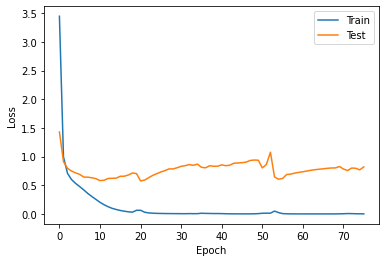

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

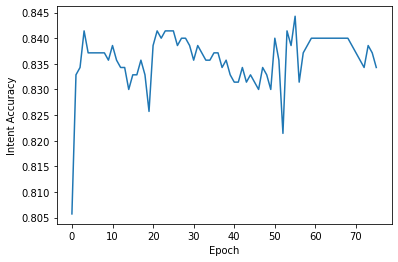

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

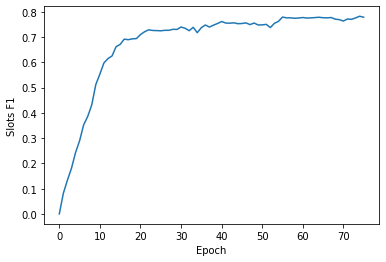

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1')
plt.plot(slots_f1)
plt.show()